# Neural Network Time Series Prediction Model
This notebook contains code to train and analyze a neural network-based model which is able to make predictions for a chosen time series, using previous values from the target sensor as well as values from all other observed sensors at the corresponding time.

In [1]:
# Imports
import glob
import keras
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn.utils
import tensorflow as tf
from pprint import pprint
import requests
import datetime
import time
import json

Using TensorFlow backend.


### Read Data
Collect and cache all time series data from the Citadel API, for use in the neural network prediction model.

In [2]:
cache_dir = 'cache/'
target_uuid = '004c9e87-c098-4842-8997-d62134f7c491'
num_autoregressive_terms = 5

# Delay between autoregressive terms and target value. In other words, skip
# this many previous values when creating the autoregressive features.
delay_length = 10

# Number of future output values to make predictions for
# Should be at least 1
num_output_values = 10

In [3]:
# Generate weekly start and end timestamps, moving back one week at a time.
# This is so we can collect data from Citadel one week at a time as the maximum
# number of points returned by a single request is currently 10000.
def get_weekly_timestamps():
    current = datetime.datetime.now()
    while True:
        next_week = current + datetime.timedelta(days=7)
        prev_week = current - datetime.timedelta(days=7)

        start_time = int(current.timestamp())
        end_time = int(next_week.timestamp())
        
        yield (start_time, end_time)
        current = prev_week


# Download and cache all time series from the Citadel API
def get_timeseries_from_api():
    # First get information about all points in the Citadel web service
    r = requests.get('https://citadel.ucsd.edu/api/point/')
    uuids = sorted([point['uuid'] for point in r.json()['point_list']])
    
    # Get time series data for every Citadel point
    for i, uuid in enumerate(uuids):
        print()
        print(uuid)
        
        base_url = 'https://citadel.ucsd.edu/api/point/' + uuid + '/timeseries'
        sensor_data = {'data': {}}
        empty_count = 0

        for start_time, end_time in get_weekly_timestamps():
            time.sleep(1)
            
            r = requests.get(base_url, params={'start_time': start_time, 'end_time': end_time})
            sensor_data['data'].update(r.json()['data'])
            
            num_data_points = len(r.json()['data'])
            print(num_data_points, end='\t')
            if num_data_points == 0:
                empty_count += 1
            elif num_data_points == 10000:
                print('Returned 10000 points')
                return
            else:
                empty_count = 0
            
            # Stop making requests after seeing 20 weeks in a row with no data
            if empty_count >= 20:
                break
                
        # Store collected data
        f = open(cache_dir + uuid + '.json', 'w')
        json.dump(sensor_data, f)
        f.close()
        
        return

In [4]:
# Read stored time series from Citadel into Pandas dataframes
def read_timeseries_from_cache():
    files = sorted(glob.glob(cache_dir + '*.json'))
    target_df = None
    dfs = []
    
    for filepath in files:
        uuid = os.path.splitext(os.path.basename(filepath))[0]
        
        f = open(filepath, 'r')
        df = pd.read_json(f)
        f.close()
        
        df = df.rename(columns={'data': uuid})
        
        if len(df) == 0:
            continue
        if df[uuid].std() < 1e-10:
            continue
        
        if uuid == target_uuid:
            target_df = df
        else:
            dfs.append(df)
    
    return (target_df, dfs)

In [5]:
# get_timeseries_from_api()
(target_df, time_series_dfs) = read_timeseries_from_cache()

In [6]:
# Normalize sensor readings and find nearest values (in time) for every target reading
for i in range(len(time_series_dfs)):
    if i % 100 == 0:
        print(i, end=' ')
        
    df = time_series_dfs[i]
    
    uuid = df.columns[0]
    df[uuid] = (df[uuid] - df[uuid].mean()) / df[uuid].std()
    
    # Find indices in the current feature df which are closest to each reading in target_df
    indices = np.searchsorted(df.index, target_df.index)
    indices[indices == len(df)] = len(df) - 1
    target_df['indices'] = df.index.get_values()[indices]
    
    # Extract corresponding sensor value for each reading in target_df
    merged = pd.merge(target_df, df, left_on='indices', right_index=True)
    time_series_dfs[i] = merged[[uuid]]

target_df = target_df.drop('indices', axis=1)

0 100 200 300 400 500 600 

### Train Neural Network Prediction Model
Use the Keras neural networks framework to train a model to predict target sensor values using the corresponding readings from all other sensors.

In [7]:
# Add autoregressive features
all_data = pd.concat([target_df] + time_series_dfs, axis=1)
for i in range(1, num_autoregressive_terms + 1):
    all_data['prev_value_' + str(i)] = all_data[target_uuid].shift(i)

all_data = all_data.iloc[num_autoregressive_terms:]

for i in range(1, num_autoregressive_terms + 1):
    colname = 'prev_value_' + str(i)
    all_data[colname] = (all_data[colname] - all_data[colname].mean()) / all_data[colname].std()

In [8]:
# Add future output terms
target_columns = [target_uuid]
for i in range(1, num_output_values):
    all_data['future_value_' + str(i)] = all_data[target_uuid].shift(-i)
    target_columns.append('future_value_' + str(i))

all_data = all_data.iloc[:-num_output_values+1]

In [9]:
# Create training and test data
shuffled_data = all_data.sample(frac=1, random_state=1)
df_train = shuffled_data.iloc[:int(0.8*len(shuffled_data))]
df_test  = shuffled_data.iloc[int(0.8*len(shuffled_data)):]

x_train = df_train.drop(target_columns, axis=1).values
y_train = df_train[target_columns].values.reshape([len(df_train), num_output_values])
x_test = df_test.drop(target_columns, axis=1).values
y_test = df_test[target_columns].values.reshape([len(df_test), num_output_values])

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu', input_shape=(len(time_series_dfs)
                                                                  + num_autoregressive_terms,)))
model.add(keras.layers.Dense(num_output_values, activation='linear'))
model.summary()

rmsprop = keras.optimizers.RMSprop(lr=1e-5)
model.compile(loss='mse', optimizer=rmsprop)
history = model.fit(x_train, y_train, batch_size=256, epochs=300, verbose=2,
                    validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               70600     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 71,610
Trainable params: 71,610
Non-trainable params: 0
_________________________________________________________________
Train on 27423 samples, validate on 6856 samples
Epoch 1/300
1s - loss: 5.5636 - val_loss: 4.8930
Epoch 2/300
1s - loss: 4.3369 - val_loss: 3.8151
Epoch 3/300
1s - loss: 3.3854 - val_loss: 2.9678
Epoch 4/300
1s - loss: 2.6404 - val_loss: 2.3137
Epoch 5/300
1s - loss: 2.0693 - val_loss: 1.8174
Epoch 6/300
1s - loss: 1.6449 - val_loss: 1.4562
Epoch 7/300
1s - loss: 1.3378 - val_loss: 1.1993
Epoch 8/300
1s - loss: 1.1246 - val_loss: 1.0229
Epoch 9/300
1s - loss: 0.9746 - val_loss: 0.8952
Epoch 10/300
1s - loss: 0.8603 - val_loss: 0

1s - loss: 0.0455 - val_loss: 0.0456
Epoch 152/300
1s - loss: 0.0453 - val_loss: 0.0455
Epoch 153/300
1s - loss: 0.0451 - val_loss: 0.0453
Epoch 154/300
1s - loss: 0.0449 - val_loss: 0.0450
Epoch 155/300
1s - loss: 0.0447 - val_loss: 0.0449
Epoch 156/300
1s - loss: 0.0444 - val_loss: 0.0447
Epoch 157/300
1s - loss: 0.0442 - val_loss: 0.0445
Epoch 158/300
1s - loss: 0.0440 - val_loss: 0.0443
Epoch 159/300
1s - loss: 0.0439 - val_loss: 0.0441
Epoch 160/300
1s - loss: 0.0437 - val_loss: 0.0439
Epoch 161/300
1s - loss: 0.0435 - val_loss: 0.0437
Epoch 162/300
1s - loss: 0.0433 - val_loss: 0.0436
Epoch 163/300
1s - loss: 0.0431 - val_loss: 0.0434
Epoch 164/300
1s - loss: 0.0429 - val_loss: 0.0433
Epoch 165/300
1s - loss: 0.0427 - val_loss: 0.0431
Epoch 166/300
1s - loss: 0.0426 - val_loss: 0.0429
Epoch 167/300
1s - loss: 0.0424 - val_loss: 0.0428
Epoch 168/300
1s - loss: 0.0422 - val_loss: 0.0426
Epoch 169/300
1s - loss: 0.0420 - val_loss: 0.0425
Epoch 170/300
1s - loss: 0.0419 - val_loss: 0

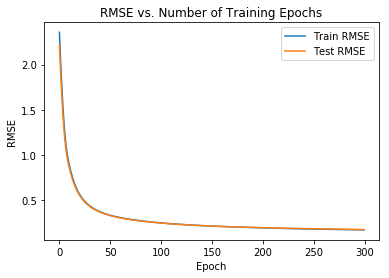

In [11]:
# Plot training and test error for each epoch
train_rmse = [np.sqrt(x) for x in history.history['loss']]
test_rmse = [np.sqrt(x) for x in history.history['val_loss']]

plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.legend(loc='best')
plt.title('RMSE vs. Number of Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

### Anomaly Detection
Plot and highlight all anomalies, defined as the points in the test data with highest prediction error. Currently, we highlight as anomalies points which are at least 3 standard deviations above or below the average test error.

Anomaly Locations:
[Timestamp('2017-01-22 22:09:00')]


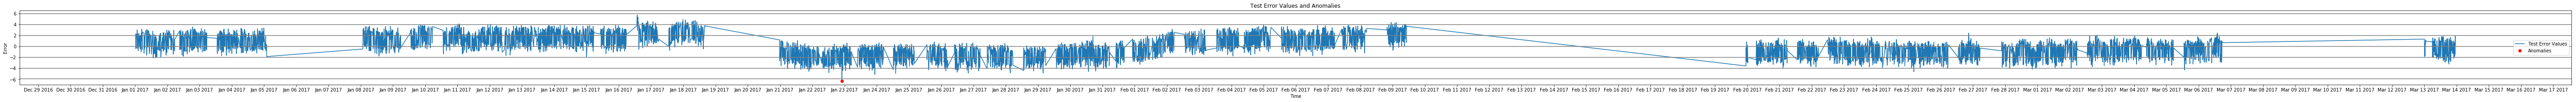

In [12]:
df_test = df_test.sort_index()
df_test['prediction'] = model.predict(x_test)[:,0]
errors = df_test[target_uuid] - df_test['prediction']

fig = plt.figure(figsize=(100, 3))
plt.plot(errors.index, errors, label='Test Error Values')

mean = np.mean(errors)
std = np.std(errors)
plt.axhline(y=mean, color='grey')
plt.axhline(y=mean + 1*std, color='gray')
plt.axhline(y=mean + 2*std, color='gray')
plt.axhline(y=mean + 3*std, color='gray')
plt.axhline(y=mean - 1*std, color='gray')
plt.axhline(y=mean - 2*std, color='gray')
plt.axhline(y=mean - 3*std, color='gray')

max_cutoff = mean + 3*std
min_cutoff = mean - 3*std
anomalies_x = []
anomalies_y = []
for i, error in enumerate(errors):
    if error > max_cutoff or error < min_cutoff:
        anomalies_x.append(errors.index[i])
        anomalies_y.append(error)

print('Anomaly Locations:')
pprint(anomalies_x)

plt.plot(mdates.date2num(anomalies_x), anomalies_y, 'o', color='red', label='Anomalies')
fig.gca().xaxis.set_major_locator(mdates.DayLocator())
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))

plt.title('Test Error Values and Anomalies')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend(loc='best')
plt.show()

df_test = df_test.drop('prediction', axis=1)

### Model Interpretation
Find the features most highly predictive of the target time series. This is done by iteratively removing (setting to 0) one feature at a time and evaluating the model on the test data. The most predictive features are those for which the test error increases the most after removing.

In [13]:
column_results = []
for i, column in enumerate(df_test.columns):
    if i % 100 == 0:
        print(i, end=' ')
    if column in target_columns:
        continue
    
    df_test_copy = df_test.copy()
    df_test_copy[column] = 0
    x_test = df_test_copy.drop(target_columns, axis=1).values
    y_test = df_test_copy[target_columns].values.reshape([len(df_test), num_output_values])
    
    test_rmse = np.sqrt(model.evaluate(x_test, y_test, verbose=0, batch_size=len(df_test)))
    column_results.append((column, test_rmse))

column_results.sort(key=lambda x: x[1], reverse=True)
print('\n')
print('20 most highly predictive features, with corresponding test RMSE:')
pprint(column_results[:20])

0 100 200 300 400 500 600 700 

20 most highly predictive features, with corresponding test RMSE:
[('237226a1-9aa8-460d-b021-5dc64dadf4cb', 0.30160807625868852),
 ('prev_value_1', 0.25964983890821547),
 ('5a3fe412-0227-4b29-8b35-82e7da93ca6a', 0.23529765196229346),
 ('0ee008d0-ab91-4a4d-a16e-8c3ae0d8edcc', 0.22574061090698055),
 ('d2d14651-338d-4143-9487-9faa921072c2', 0.21963170865222881),
 ('d4948af4-d6b5-4286-8867-9bfffac68632', 0.21955429953939357),
 ('7141a945-8712-470d-8cd8-fe54e2d37f19', 0.21920793149087464),
 ('acb61e3a-ab90-4ebe-9492-f6df3dc8fbf7', 0.21209105558301233),
 ('prev_value_3', 0.20848564103880055),
 ('prev_value_2', 0.20447704692706384),
 ('prev_value_4', 0.202297165195513),
 ('prev_value_5', 0.20043309674423765),
 ('bd1043eb-5e45-420c-bd89-5bdce53b0c5c', 0.19103287265973926),
 ('9eb78228-9caa-4dd5-a43d-6a7e4ff73fcd', 0.19017505739248028),
 ('75393e09-75eb-4aa4-bf80-98753da0b207', 0.18807571161503903),
 ('f6d42eda-26cc-4a74-9b93-c347dcd29c39', 0.18709220847301891),
